# Importing necessary libraries

In [5]:
import matplotlib.pyplot as plt
import sys
import pickle
import pandas as pd
import numpy as np
import math
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import preprocbessing
from sklearn import cross_validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from time import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.grid_search import GridSearchCV
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
import pprint
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
import warnings
warnings.filterwarnings('ignore')
from sklearn import tree

## Loading the dataset and selecting features to be used

In [24]:
# %load poi_id.py
#!/usr/bin/python


### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi', 'salary', 'deferral_payments', 'total_payments',
                 'loan_advances', 'bonus', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses',
                 'exercised_stock_options', 'long_term_incentive', 'restricted_stock', 'director_fees']

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

## Data Exploration

In [7]:
#Sample data for one of the people in the dataset "Jeffrey Skilling"
print data_dict["SKILLING JEFFREY K"]

#Number of people in the datasets

print "Total number of people in the dataset: " + str(len(data_dict))

#Number of features in the dataset

print "Total number of features in the dataset: " + str(len(data_dict["SKILLING JEFFREY K"]))

#Number of POIs in the dataset

poi_count = 0
for i in data_dict:
    if data_dict[i]['poi']==True:
        poi_count=poi_count+1
print 'Number of poi in the dataset:', poi_count

{'salary': 1111258, 'to_messages': 3627, 'deferral_payments': 'NaN', 'total_payments': 8682716, 'exercised_stock_options': 19250000, 'bonus': 5600000, 'restricted_stock': 6843672, 'shared_receipt_with_poi': 2042, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 26093672, 'expenses': 29336, 'loan_advances': 'NaN', 'from_messages': 108, 'other': 22122, 'from_this_person_to_poi': 30, 'poi': True, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 1920000, 'email_address': 'jeff.skilling@enron.com', 'from_poi_to_this_person': 88}
Total number of people in the dataset: 146
Total number of features in the dataset: 21
Number of poi in the dataset: 18


## Detecting the outlier

8000000.0


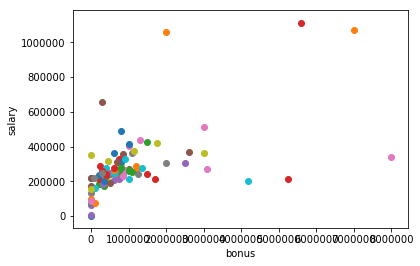

In [26]:
### Task 2: Remove outliers

# first, we will check for outliers in the data by plotting it!
features = ["bonus","salary"]
data = featureFormat(data_dict, features)
print(data.max())

for point in data:
    bonus = point[0]
    salary = point[1]
    plt.scatter( bonus, salary )

plt.xlabel("bonus")
plt.ylabel("salary")
plt.show()

# and as is it appears that we have one very imporant outlier, we just need to figure out which data point is it ?!

# for point in data:
#     salary = point[0]
#     bonus = point[1]
#     matplotlib.pyplot.scatter( salary, bonus )

# matplotlib.pyplot.xlabel("salary")
# matplotlib.pyplot.ylabel("bonus")
# matplotlib.pyplot.show()

for i, v in data_dict.items():
    if v['salary'] != 'NaN' and v['salary'] > 10000000:
        print "Outliers: ", i
        
        
# and as it turned out that it was not a person !, but it was the "Total", so in this case removing the outlier 
# would be the right move to make ..

## Removing the outlier

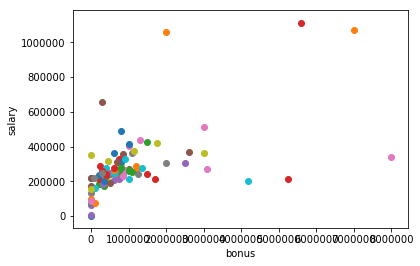

In [27]:
features = ["bonus","salary"]
data = featureFormat(data_dict, features)

data_dict.pop('TOTAL', 0)


# now let's take another look at the plot after removing the outlier


for point in data:
    bonus = point[0]
    salary = point[1]
    plt.scatter( bonus, salary )

plt.xlabel("bonus")
plt.ylabel("salary")
plt.show()

# and now  we have more normal plot, with the high data points being are people susbected for fraud "POI"

## Removing NaN values 

In [10]:
# Load data into Pandas
df = pd.DataFrame.from_records(list(data_dict.values()))

# Convert to numpy nan
df.replace(to_replace='NaN', value=np.nan, inplace=True)
# df = df.replace(np.nan,'NaN', regex=True)

# DataFrame dimension
print df.shape
# print df.head()

# First, we will check for missing values and delete them, if found
print "Number of NaN's in each coulmn before cleaning: ", df.isnull().sum()

# it turns out we have huge number of NaN's value in each column
# next we will remove them to ensure data authenticity

df_imp = df.replace(to_replace=np.nan, value=0)
df_imp = df.fillna(0).copy(deep=True)
df_imp.columns = list(df.columns.values)
print "Number of NaN's in each coulmn after cleaning: ", df_imp.isnull().sum()

(145, 21)
Number of NaN's in each coulmn before cleaning:  bonus                         64
deferral_payments            107
deferred_income               97
director_fees                129
email_address                 34
exercised_stock_options       44
expenses                      51
from_messages                 59
from_poi_to_this_person       59
from_this_person_to_poi       59
loan_advances                142
long_term_incentive           80
other                         53
poi                            0
restricted_stock              36
restricted_stock_deferred    128
salary                        51
shared_receipt_with_poi       59
to_messages                   59
total_payments                21
total_stock_value             20
dtype: int64
Number of NaN's in each coulmn after cleaning:  bonus                        0
deferral_payments            0
deferred_income              0
director_fees                0
email_address                0
exercised_stock_options      0
e

## Creating new feature

In [28]:
### Task 3: Create new feature(s)


### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
 
    
# now we will add new feature into our dataset, which is the bonus to salary ratio 

for key in data_dict:
    ratio = float(data_dict[key]['bonus'])/float(data_dict[key]['salary'])
    if math.isnan(ratio):
        data_dict[key]['bonus_salary_ratio'] = 0
    else:
        data_dict[key]['bonus_salary_ratio'] = ratio

### Store to my_dataset for easy export below.
my_dataset = data_dict        


# features_list += ['bonus_salary_ratio']

# we added 'bonus salary ratio' as a new feature, next we will go through our feature selection process
# to decide which features to use


features_list

['poi',
 'salary',
 'deferral_payments',
 'total_payments',
 'loan_advances',
 'bonus',
 'restricted_stock_deferred',
 'deferred_income',
 'total_stock_value',
 'expenses',
 'exercised_stock_options',
 'long_term_incentive',
 'restricted_stock',
 'director_fees',
 'bonus_salary_ratio']

## Feature Selection

In [29]:
### Extract features and labels from dataset for local testing
data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)




# for i in range(len(labels)):
#     labels[i] = int(labels[i])


# # labels and features print statements:
# print "Labels", labels

# for i in range(len(features)):
#     print "Features ", features[i]


selection=SelectKBest(k=4).fit(features,labels)
scores=selection.scores_
unsorted_pairs = zip(features_list[1:], scores)
sorted_pairs=list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
selection_best = dict(sorted_pairs[:4])
print selection_best

{'bonus': 21.060001707536571, 'exercised_stock_options': 25.097541528735491, 'salary': 18.575703268041785, 'total_stock_value': 24.467654047526398}


### since we got our new feature got the lowest KBest score, I think it would be best if I just remove it 

In [13]:
features_list = ['poi','salary', 'bonus', 'exercised_stock_options', 'total_stock_value']

## Feature Scaling

In [30]:
# Feature Scaling through MinMaxScale

data = featureFormat(data_dict, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

## Splitting the dataset into training and testing data

In [31]:
features_train,features_test,labels_train,labels_test = cross_validation.train_test_split(features,labels, test_size=0.3, 
                                                                                          random_state=42)

## Trying out some classifiers  

In [87]:
### Task 4: Try a varity of classifiers

# Naive Bayes

clf = GaussianNB()
clf.fit(features_train,labels_train)

print("Naive Bayes Classifier: ")
print "Accuracy: " + str(accuracy_score(labels_test,pred))
print "Precision Score: " + str(precision_score(labels_test,pred))
print "Recall Score: " + str(recall_score(labels_test,pred))

Naive Bayes Classifier: 
Accuracy: 0.454545454545
Precision Score: 0.172413793103
Recall Score: 1.0


In [16]:
# Decision Tree

clf = tree.DecisionTreeClassifier() 
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)

print("Decision Tree Classifier: ")
print "Accuracy: " + str(accuracy_score(labels_test,pred))
print "Precision Score: " + str(precision_score(labels_test,pred))
print "Recall Score: " + str(recall_score(labels_test,pred))

Decision Tree Classifier: 
Accuracy: 0.820512820513
Precision Score: 0.2
Recall Score: 0.25


In [86]:
# SVC

clf = SVC()
clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
print("SVC Classifier: ")
print "Accuracy: " + str(accuracy_score(labels_test,pred))
print "Precision Score: " + str(precision_score(labels_test,pred))
print "Recall Score: " + str(recall_score(labels_test,pred))

SVC Classifier: 
Accuracy: 0.886363636364
Precision Score: 0.0
Recall Score: 0.0


## Classifier Tunning using Grid Search

In [80]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall

# Decision Tree

parameters = {'max_depth': [1,2,3,4,5,6,7,8,9,10],'min_samples_split':[2,3,4,5], 'max_leaf_nodes':[5,10,30],
              'min_samples_leaf':[1,2,3,4,5,6,7,8], 'criterion':('gini', 'entropy'), 'splitter' : ('best','random')}



clf = tree.DecisionTreeClassifier() 
clf = GridSearchCV(clf, parameters, 'f1')
clf = clf.fit(features, labels)
print clf.best_estimator_

0.514652014652
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=30, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random')
{'splitter': 'random', 'max_leaf_nodes': 30, 'min_samples_leaf': 1, 'criterion': 'entropy', 'min_samples_split': 2, 'max_depth': 10}


In [65]:
# SVC

parameters = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear','rbf'], 'gamma': [0.001, 0.0001]}]

clf = SVC()
clf = GridSearchCV(clf, parameters, 'recall')
clf = clf.fit(features, labels)
print clf.best_score_
print clf.best_estimator_
print clf.best_params_

0.875
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
{'kernel': 'rbf', 'C': 10, 'gamma': 0.001}


## Testing the best estimator against the test_classifier test set

In [81]:
from tester import test_classifier
test_classifier(clf.best_estimator_, my_dataset, features_list)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=30, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random')
	Accuracy: 0.81307	Precision: 0.30409	Recall: 0.31200	F1: 0.30800	F2: 0.31039
	Total predictions: 15000	True positives:  624	False positives: 1428	False negatives: 1376	True negatives: 11572



## Dumping the classifier, dataset and feature list

In [82]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)